In [ ]:
import scikitplot as skplt

import pandas as pd 
from sklearn import metrics

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# we use tensorflow to create our neural network for this experiment 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [25]:
%cd '/content/gdrive/Shared drives/PFE/Colab Notebooks/cleaned/authority'
df = pd.read_csv('./data/authority_dataset.csv')
df

/content/gdrive/Shared drives/PFE/Colab Notebooks/cleaned/authority


,ad,auth
0,north korea officially has no corona cases how...,1
1,it seems difficult to stand for something one ...,0
2,senator bernie sanders held a rally with randy...,1
3,life gets busy—don’t wait to send back your ba...,0
4,some issues feel impossible to compromise on b...,1
...,...,...
49661,a recent poll shows sherrod with just a one po...,0
49662,today’s donor goal ⃣ ⃣ ⃣ our endofquarter dead...,0
49663,you’ve been selected after a year of chaos hat...,1
49664,after receiving the corona vaccine a video tha...,0


In [9]:
norm_train, norm_test, y_train, y_test  = train_test_split(df['ad'], df['auth'], test_size = 0.33, random_state=42)

In [11]:
# data tokenization 
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')

# fit the tokenizer on the training documents
t.fit_on_texts(norm_train)
t.word_index['<PAD>'] = 0
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('nfi', 54255), ('<PAD>', 0), 1)

In [12]:
# create tokenized data sequences to feed to the neural network 
train_sequences = t.texts_to_sequences(norm_train)
test_sequences = t.texts_to_sequences(norm_test)

In [13]:
MAX_SEQUENCE_LENGTH = 1000

# pad documents to equal length with 0 
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((33276, 1000), (16390, 1000))

In [14]:
def create_model(units, vocab_size, embedding_dim, maxlen, dropout = 0.2):
  '''
    Create a simple artificial neural network for binary text classification
    Arguments : 
      num_filters: number of filters to use for the 1D convolution layer 
      kernel_size: kernal size used for convolution
      embedding_dim: embedding size 
      maxlen: input sequence length
      vectorize_layer : vectorization layer for turning input text to numerical sequences
      dropout : dropout rate used for Dropout regularization layer to minimize overfitting

    Returns : 
    A model with the folowing layers:  
            - An Embedding layer with embedding_dim dimension for each embedding 
            - A one dimentional global max pooling layer  
            - A fully connected layer with units number of units
            - A sigmoid activation layer to produce output
            - Dropout layers added to minimize overfitting on the small datasets 
  '''
  model = Sequential([
      layers.Input(shape=(maxlen,)),
      layers.Embedding(input_dim = vocab_size , output_dim = embedding_dim, input_length=maxlen),
      layers.Dropout( rate = dropout ),
      layers.GlobalMaxPooling1D(),
      layers.Dropout( rate = dropout),
      layers.Dense(units, activation='relu'),
      layers.Dropout( rate = dropout ),
      layers.Dense(1, activation='sigmoid')              
  ])
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [16]:
VOCAB_SIZE = len(t.word_index)

EMBEDDING_DIM = 50
UNITS = 10

# Creating a neural net with randomly set paramteres as a baseline comparison model 
model = create_model(units = UNITS, vocab_size = VOCAB_SIZE, embedding_dim = EMBEDDING_DIM, maxlen = MAX_SEQUENCE_LENGTH )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          2712800   
                                                                 
 dropout (Dropout)           (None, 1000, 50)          0         
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                        

In [18]:
# Train the neural net and evaluate results 
# the model is already trained and saved in the ann_model.h5 file
history = model.fit(X_train, y_train, epochs= 5, batch_size= 32,  shuffle=True, validation_split=0.33, verbose=1)
model.save('./saved_models/ann_model.h5')

Epoch 1/5
697/697 [==============================] - 52s 75ms/step - loss: 0.3578 - accuracy: 0.8535 - val_loss: 0.1419 - val_accuracy: 0.9646
Epoch 2/5
697/697 [==============================] - 46s 66ms/step - loss: 0.1224 - accuracy: 0.9612 - val_loss: 0.0808 - val_accuracy: 0.9793
Epoch 3/5
697/697 [==============================] - 41s 59ms/step - loss: 0.0656 - accuracy: 0.9805 - val_loss: 0.0708 - val_accuracy: 0.9809
Epoch 4/5
697/697 [==============================] - 42s 60ms/step - loss: 0.0407 - accuracy: 0.9884 - val_loss: 0.0682 - val_accuracy: 0.9799
Epoch 5/5
697/697 [==============================] - 41s 59ms/step - loss: 0.0269 - accuracy: 0.9925 - val_loss: 0.0661 - val_accuracy: 0.9805


513/513 [==============================] - 2s 4ms/step - loss: 0.0642 - accuracy: 0.9804
Accuracy: 98.04%
              precision    recall  f1-score   support

no-authority       0.98      0.98      0.98      8190
   authority       0.98      0.98      0.98      8200

    accuracy                           0.98     16390
   macro avg       0.98      0.98      0.98     16390
weighted avg       0.98      0.98      0.98     16390

confusion matrix:
[[8059  131]
 [ 190 8010]]



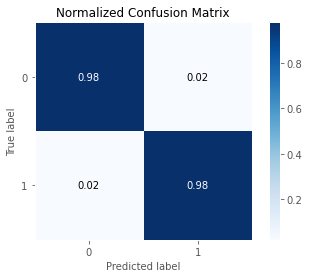

In [19]:
# get model predictions 
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]

scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

print(metrics.classification_report(y_test, predictions, target_names=['no-authority', 'authority']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()

skplt.metrics.plot_confusion_matrix(y_test, predictions , normalize=True)
plt.show()

In [22]:
df_val = pd.read_csv('./data/validation_dataset.csv')
df_val

,ad,auth
0,please share in order to do well in the precin...,1
1,for far too long many in this country have pro...,0
2,todco proposed “housing first” central soma pl...,1
3,the latest census bureau data confirms women a...,0
4,did you think we were done organizing just bec...,0
...,...,...
17294,the way this green party candidate is getting ...,0
17295,on your votes projects are proposed to the vot...,0
17296,bbq campaign kickoff as we get ready to run fo...,1
17297,the white house chief of staff is the latest v...,1


accuracy:   0.983
              precision    recall  f1-score   support

no authority       0.98      0.99      0.98      8649
   authority       0.99      0.98      0.98      8650

    accuracy                           0.98     17299
   macro avg       0.98      0.98      0.98     17299
weighted avg       0.98      0.98      0.98     17299

confusion matrix:
[[8528  121]
 [ 173 8477]]



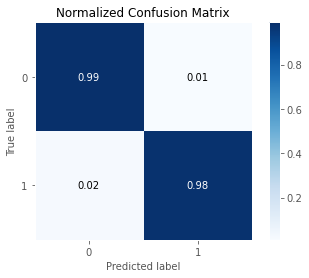

In [23]:
val_sequences = t.texts_to_sequences(df_val['ad'])
X_val = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
y_val = df_val['auth']

prediction_probs = model.predict(X_val).ravel()
y_pred  = [1 if prob > 0.5 else 0 for prob in prediction_probs]


score = metrics.accuracy_score(y_val, y_pred)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_val, y_pred, target_names=[ 'no authority', 'authority']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_val, y_pred))
print()

skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True)plt.show()

In [26]:
# we use the saved model to make predictions on the manually annotated data
new_model = tf.keras.models.load_model('./saved_models/ann_model.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          2712800   
                                                                 
 dropout (Dropout)           (None, 1000, 50)          0         
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                        

4/4 [==============================] - 0s 7ms/step - loss: 1.4943 - accuracy: 0.7593
Accuracy: 75.93%
4/4 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

no authority       0.71      0.87      0.78        54
   authority       0.83      0.65      0.73        54

    accuracy                           0.76       108
   macro avg       0.77      0.76      0.76       108
weighted avg       0.77      0.76      0.76       108

confusion matrix:
[[47  7]
 [19 35]]



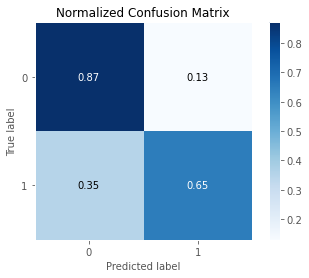

In [30]:
# sample dataset contains manually annotated data
df_val = pd.read_csv('./data/sample_auth.csv')

val_sequences = t.texts_to_sequences(df_val['ad'])
X_val = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
y_val = df_val['authority']

scores = new_model.evaluate(X_val, y_val, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

prediction_probs = new_model.predict(X_val, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]

print(metrics.classification_report(y_val, predictions, target_names=[ 'no authority', 'authority']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_val,predictions))
print()

skplt.metrics.plot_confusion_matrix(y_val, predictions, normalize=True)
plt.show()